# Combine datasets into a single spatially unified dataset 

In [1]:
## Import libraries
# system
import os
import sys
import time
import calendar
import io
import requests
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from dotenv import load_dotenv
import logging

# data manipulation
from functools import reduce
import itertools
import json
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.transform import from_bounds
from rasterio.features import geometry_mask, rasterize
from pyproj import Transformer, CRS
from shapely.geometry import box, shape, Polygon
#from samgeo import tms_to_geotiff

# visualization
from rasterio.plot import show
import folium
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

repo_name = 'masterthesis_genai_spatialplan'
if not repo_name in os.getcwd():
    os.chdir(repo_name)

p=os.popen('git rev-parse --show-toplevel')
repo_dir = p.read().strip()
p.close()

#seaborn cmap
rocket=sns.color_palette("rocket", as_cmap=True)
mako=sns.color_palette("mako", as_cmap=True)

## Load and explore the data

Planetscope data

In [2]:
planet_xs=xr.open_zarr(f"{repo_dir}/data/planet_scope_20190624.zarr")
planet_xs

c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\codecs\vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.Dataset> Size: 500MB
Dimensions:               (time: 1, channel: 4, y: 5635, x: 5544)
Coordinates:
  * x                     (x) float64 44kB 3.097e+05 3.097e+05 ... 3.263e+05
  * y                     (y) float64 45kB 5.7e+06 5.7e+06 ... 5.683e+06
    spatial_ref           int64 8B ...
  * channel               (channel) object 32B 'blue' 'green' 'red' 'nir'
  * time                  (time) datetime64[ns] 8B 2019-06-24
Data variables:
    planetscope_sr_4band  (time, channel, y, x) int16 250MB dask.array<chunksize=(1, 4, 1024, 1024), meta=np.ndarray>
    ndvi                  (time, y, x) float64 250MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

OSM data

In [3]:
osm_landuse_xs = xr.open_zarr(f"{repo_dir}/data/osm/osm_rasterized.zarr", consolidated=True, decode_times=False)
osm_landuse_xs

<xarray.Dataset> Size: 968MB
Dimensions:            (y: 5500, x: 5500)
Coordinates:
    spatial_ref        int64 8B ...
  * y                  (y) float64 44kB 51.42 51.42 51.42 ... 51.27 51.27 51.27
  * x                  (x) float64 44kB 12.27 12.27 12.27 ... 12.5 12.5 12.5
Data variables:
    buildings          (y, x) float32 121MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    streets            (y, x) float32 121MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    buildings_heights  (y, x) float32 121MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    water              (y, x) float32 121MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    landuse            (y, x) float32 121MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    buildings_service  (y, x) float32 121MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    streets_service    (y, x) float32 121MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    streets_surface    (y, x) float32 121MB dask.array<chunksize=(344, 688), meta=np.ndarray>
Attributes:
    long_name:    Streets OSM
    description:  Rasterized streets from OSM data
    units:        1
    spatial_ref:  EPSG:4326

Landsat LST data

In [4]:
drop_vars = ['qa_pixel',
 'stac_id',
 'view_sun_azimuth',
 'surface_temp_b10',
 'view_off_nadir',
 'view_sun_elevation']

lst_xs = xr.open_zarr(f"{repo_dir}/data/landsat_temperature_gt_2018_2022.zarr", consolidated=True, decode_times=False, drop_variables=drop_vars)

# rename surface_temp_b10 to land_surface_temp
lst_xs = lst_xs.rename({"surface_temp_b10_masked": "landsat_surface_temp_b10_masked"})

#convert time values to pandas datetime
lst_xs['time'] = xr.DataArray(
    data=pd.to_datetime(lst_xs['time'].values).tz_localize(None),
    dims='time',
    coords={'time': pd.to_datetime(lst_xs['time'].values).tz_localize(None)}
)

lst_xs.rio.write_crs("EPSG:32633", inplace=True)  # <-- Use UTM 33N!
lst_xs.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
lst_xs

c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\codecs\vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.Dataset> Size: 6MB
Dimensions:                          (time: 5, y: 563, x: 554)
Coordinates:
  * time                             (time) datetime64[ns] 40B 2018-07-23T10:...
  * x                                (x) float64 4kB 3.097e+05 ... 3.263e+05
  * y                                (y) float64 5kB 5.7e+06 ... 5.683e+06
    spatial_ref                      int64 8B 0
Data variables:
    landsat_surface_temp_b10_masked  (time, y, x) float32 6MB dask.array<chunksize=(2, 282, 277), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Point
    title:          Landsat 8 Surface Temperature
    description:    Landsat 8 Surface Temperature data from USGS for specific...
    source:         USGS
    bbox:           {"type": "FeatureCollection", "features": [{"id": "0", "t...
    variables:      {'surface_temp_b10': 'Surface Temperature Band (B10)', 'q...
    units:          {'surface_temp_b10': '°C', 'qa_pixel': '1', 'surface_temp...

In [5]:
# ######### find a common extent for landuse and input
# # get the extent of the input image
# bounds = satellite_data.rio.bounds()
# geom = box(*bounds)
# satellite_gdf = gpd.GeoDataFrame(geometry=[geom], crs=satellite_data.rio.crs)

# # get the extent of the landuse mask
# landuse_bounds = osm_landuse_xs.rio.bounds()
# landuse_geom = box(*landuse_bounds)
# landuse_gdf = gpd.GeoDataFrame(geometry=[landuse_geom], crs=osm_landuse_xs.rio.crs)

# #get common extent
# common_bounds = satellite_gdf.geometry.intersection(landuse_gdf.geometry).bounds.iloc[0]
# common_bounds_gdf = gpd.GeoDataFrame(geometry=[box(*common_bounds)], crs=satellite_gdf.crs)

# m = satellite_gdf.explore(color="white", name="Merged PlanetScope", show=True, zoom=12)
# landuse_gdf.explore(m=m, color="red", name="Landuse")
# common_bounds_gdf.explore(m=m, color="blue", name="Common Bounds")
# m.add_child(folium.LayerControl())
# display(m)

# # mask landuse to the common extent
# osm_landuse_xs_masked = osm_landuse_xs.rio.clip_box(*common_bounds, crs=osm_landuse_xs.rio.crs)

## Unify coordinates

Reproject/resample all variables of the OSM dataset to the same coordinate system as the PlanetScope data

In [5]:
### for each DataArray transform crs to planet crs
reprojected_dataset = {}
for var in osm_landuse_xs.data_vars:
    print(f"Reprojecting {var}...")
    reprojected_dataset[var] = osm_landuse_xs[var].rio.reproject( # uses nn resampling by default --> https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject
        planet_xs.rio.crs,
        shape=planet_xs.rio.shape,
        transform=planet_xs.rio.transform()
    )

osm_landuse_xs = xr.Dataset(reprojected_dataset)

#fil nan with 0
# osm_landuse_xs = osm_landuse_xs.fillna(0)

print(osm_landuse_xs.rio.crs)

Reprojecting buildings...
Reprojecting streets...
Reprojecting buildings_heights...
Reprojecting water...
Reprojecting landuse...
Reprojecting buildings_service...
Reprojecting streets_service...
Reprojecting streets_surface...
EPSG:32633


Reduce landsat to a single LST variable dataset and reproject/resample it

In [6]:
print("Landsat bounds:", lst_xs.rio.bounds())
print("Planet bounds:", planet_xs.rio.bounds())

print("Landsat crs:", lst_xs.rio.crs)
print("Planet crs:", planet_xs.rio.crs)

print("Landsat coordinates:")
print("Landsat x:", lst_xs.x.values[:5])
print("Landsat y:", lst_xs.y.values[:5])

Landsat bounds: (309675.0, 5682885.0, 326295.0, 5699775.0)
Planet bounds: (309666.0, 5682870.0, 326298.0, 5699775.0)
Landsat crs: EPSG:32633
Planet crs: EPSG:32633
Landsat coordinates:
Landsat x: [309690. 309720. 309750. 309780. 309810.]
Landsat y: [5699760. 5699730. 5699700. 5699670. 5699640.]


In [7]:
reprojected_slices = []
for i in range(len(lst_xs.time)):
    print(f"Reprojecting {lst_xs.time[i].values}...")
    reprojected = lst_xs.isel(time=i).rio.reproject( # uses nn resampling by default --> https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject
        planet_xs.rio.crs,
        shape=planet_xs.rio.shape,
        transform=planet_xs.rio.transform()
    )
    # Add time coordinate back
    reprojected = reprojected.expand_dims(time=[lst_xs.time[i].values])
    reprojected_slices.append(reprojected)

# concat along time
lst_xs = xr.concat(reprojected_slices, dim="time")

Reprojecting 2018-07-23T10:02:10.415562000...


Reprojecting 2019-06-24T10:02:49.679300000...
Reprojecting 2019-07-26T10:02:57.950004000...
Reprojecting 2022-08-03T10:03:23.964475000...
Reprojecting 2023-09-07T10:02:55.345240000...


### Merge datasets

In [8]:
merged_xs = xr.merge(
    [planet_xs, lst_xs, osm_landuse_xs],
    compat="override",
    join="outer",
    fill_value=np.nan,
)

# convert to minute precision
merged_xs['time'] = xr.DataArray(
    pd.to_datetime(merged_xs['time'].values).floor('min'),
    dims='time'
)

merged_xs

<xarray.Dataset> Size: 9GB
Dimensions:                          (x: 5544, y: 5635, channel: 4, time: 6)
Coordinates:
  * x                                (x) float64 44kB 3.097e+05 ... 3.263e+05
  * y                                (y) float64 45kB 5.7e+06 ... 5.683e+06
  * channel                          (channel) object 32B 'blue' ... 'nir'
  * time                             (time) datetime64[ns] 48B 2018-07-23T10:...
    spatial_ref                      int64 8B ...
Data variables:
    planetscope_sr_4band             (time, channel, y, x) float64 6GB dask.array<chunksize=(1, 4, 1024, 1024), meta=np.ndarray>
    ndvi                             (time, y, x) float64 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    landsat_surface_temp_b10_masked  (time, y, x) float32 750MB nan nan ... nan
    buildings                        (y, x) float32 125MB nan nan ... nan nan
    streets                          (y, x) float32 125MB nan nan ... nan nan
    buildings_heights                (y, x) float32 125MB nan nan ... nan nan
    water                            (y, x) float32 125MB nan nan ... nan nan
    landuse                          (y, x) float32 125MB nan nan ... nan nan
    buildings_service                (y, x) float32 125MB nan nan ... nan nan
    streets_service                  (y, x) float32 125MB nan nan ... nan nan
    streets_surface                  (y, x) float32 125MB nan nan ... nan nan

Save to zarr

In [14]:
merged_xs.to_zarr(
    f"{repo_dir}/data/model_input_dataset.zarr",
    mode="w",
    consolidated=True,
    compute=True,
)

c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\xarray\core\dataset.py:2270: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]
c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\codecs\vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\core\array.py:4257: UserWarning: The dtype `StringDType()` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\codecs\vlen_utf8.py:44: UserWarning

Open zarr

In [2]:
merged_xs = xr.open_zarr(
    f"{repo_dir}/data/model_input_dataset.zarr",
    consolidated=True,
)
merged_xs

c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\codecs\vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.Dataset> Size: 5GB
Dimensions:                          (y: 5635, x: 5544, time: 6, channel: 4)
Coordinates:
  * channel                          (channel) object 32B 'blue' ... 'nir'
  * time                             (time) datetime64[ns] 48B 2018-07-23T10:...
  * x                                (x) float64 44kB 3.097e+05 ... 3.263e+05
    spatial_ref                      int64 8B ...
  * y                                (y) float64 45kB 5.7e+06 ... 5.683e+06
Data variables:
    buildings_service                (y, x) float32 125MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    landuse                          (y, x) float32 125MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    ndvi                             (time, y, x) float64 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    planetscope_sr_4band             (time, channel, y, x) int16 1GB dask.array<chunksize=(1, 4, 1024, 1024), meta=np.ndarray>
    streets_service                  (y, x) float32 125MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    landsat_surface_temp_b10_masked  (time, y, x) float32 750MB dask.array<chunksize=(2, 282, 277), meta=np.ndarray>
    buildings_heights                (y, x) float32 125MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    streets                          (y, x) float32 125MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    buildings                        (y, x) float32 125MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    water                            (y, x) float32 125MB dask.array<chunksize=(344, 688), meta=np.ndarray>
    streets_surface                  (y, x) float32 125MB dask.array<chunksize=(344, 688), meta=np.ndarray>

In [ ]:
# merged_xs = merged_xs.fillna(0)

### Plot side by side

In [3]:
def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

In [4]:
def mask_to_colorimg(mask, class_dict=None, custom_colors=None, random_seed=42):
    """
    Convert a class mask to a colored image.
    
    Args:
        mask: 2D numpy array with class indices
        class_dict: Dictionary mapping class indices to class names (optional)
        custom_colors: Optional dict mapping class values to RGB colors
        random_seed: Seed for random color generation to ensure consistency
    
    Returns:
        RGB image as numpy array with shape (height, width, 3)
    """
    # Set random seed for reproducible colors
    random.seed(random_seed)
    
    # Generate distinct colors 
    if custom_colors is None:
        distinct_colors = [
            [0,0,0],      # Black
            [255, 0, 0],    # Red
            [0, 255, 0],    # Green
            [0, 0, 255],    # Blue
            [255, 255, 0],  # Yellow
            [255, 0, 255],  # Magenta
            [0, 255, 255],  # Cyan
            [128, 0, 0],    # Maroon
            [0, 128, 0],    # Dark Green
            [0, 0, 128],    # Navy
            [128, 128, 0],  # Olive
            [128, 0, 128],  # Purple
            [0, 128, 128],  # Teal
            [192, 192, 192],# Silver
            [128, 128, 128],# Gray
            [255, 165, 0],  # Orange
        ]
        
        # Map each class to a color
        color_map = {}
        if class_dict is not None:
            # map classes to colors
            for i, class_label in enumerate(class_dict.values()):
                if i < len(distinct_colors):
                    color_map[class_label] = distinct_colors[i]
                else:
                    # Fall back to random colors if more classes than distinct colors
                    color_map[class_label] = [random.randint(0, 255) for _ in range(3)]
        else:
            # use unique values from the mask
            unique_values = np.unique(mask)
            for i, val in enumerate(unique_values):
                if i < len(distinct_colors):
                    color_map[val] = distinct_colors[i]
                else:
                    color_map[val] = [random.randint(0, 255) for _ in range(3)]
    else:
        # Use custom color mapping if provided
        color_map = custom_colors
    
    # Default color for undefined classes
    default_color = [0, 0, 0]  # Black
    
    # Convert the mask to a color image
    flat_mask = mask.flatten()
    colorimg = np.array([color_map.get(val, default_color) for val in flat_mask])
    
    return colorimg.reshape(mask.shape + (3,))

In [10]:
###### Load the datasets
# Load the satellite data
satellite_data = merged_xs.planetscope_sr_4band.isel(time=1)

# Get the individual bands
blue_band = satellite_data.sel(channel='blue')
green_band = satellite_data.sel(channel='green')
red_band = satellite_data.sel(channel='red')
nir_band = satellite_data.sel(channel='nir')

# Stack these into an RGB image for input
rgb_image = np.stack([red_band, green_band, blue_band], axis=-1) 

# Percentile-based contrast stretch
p_low, p_high = 2, 98
rgb_min = np.nanpercentile(rgb_image, p_low)
rgb_max = np.nanpercentile(rgb_image, p_high)
rgb_image = np.clip((rgb_image - rgb_min) / (rgb_max - rgb_min), 0, 1)


# Load target masks for landuse, buildings, and streets
ndvi_mask = merged_xs.ndvi.isel(time=1).values
landuse_mask = merged_xs.landuse.values
buildings_mask = merged_xs.buildings.values
buildings_service_mask = merged_xs.buildings_service.values
buildings_height_mask = merged_xs.buildings_heights.values
streets_mask = merged_xs.streets.values
streets_surface_mask = merged_xs.streets_surface.values
streets_service_mask = merged_xs.streets_service.values
water_mask = merged_xs.water.values
lst_mask = merged_xs.landsat_surface_temp_b10_masked.drop_sel(time=merged_xs.planetscope_sr_4band.time[1].values).sel(time=pd.to_datetime(merged_xs.planetscope_sr_4band.time[1].values), method="nearest").values

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# Convert masks to RGB
ndvi_mask_rgb = mask_to_colorimg(ndvi_mask, custom_colors={0: [0, 0, 0], 1: [0, 255, 0]})
landuse_mask_rgb = mask_to_colorimg(landuse_mask, json.loads(merged_xs.landuse.attrs["landuse_mapping"]))
buildings_mask_rgb = mask_to_colorimg(buildings_mask)
buildings_services_mask_rgb = mask_to_colorimg(buildings_service_mask, json.loads(merged_xs.buildings_service.attrs["buildings_service_mapping"]))
buildings_height_mask_rgb = mask_to_colorimg(buildings_height_mask)
streets_mask_rgb = mask_to_colorimg(streets_mask)
streets_surface_mask_rgb = mask_to_colorimg(streets_surface_mask, json.loads(merged_xs.streets_surface.attrs["streets_surface_mapping"]))
streets_service_mask_rgb = mask_to_colorimg(streets_service_mask, json.loads(merged_xs.streets_service.attrs["streets_service_mapping"]))
water_mask_rgb = mask_to_colorimg(water_mask, json.loads(merged_xs.water.attrs["water_mapping"]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


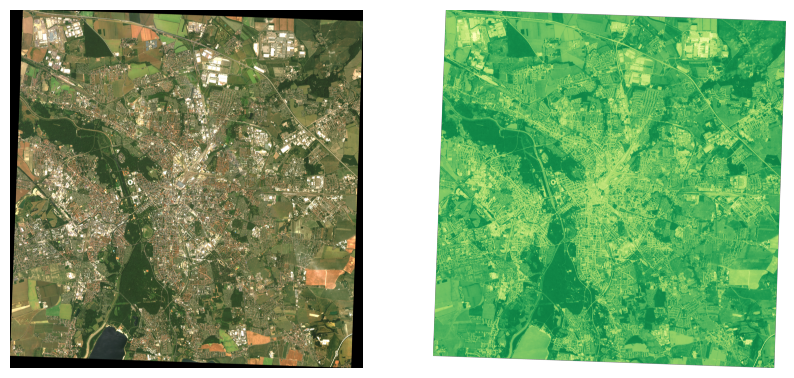

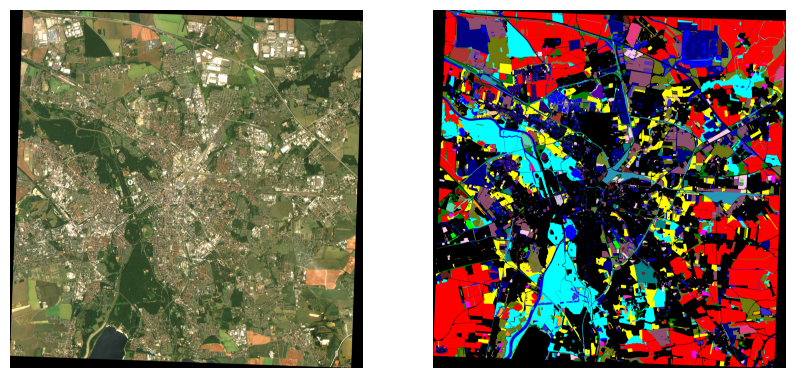

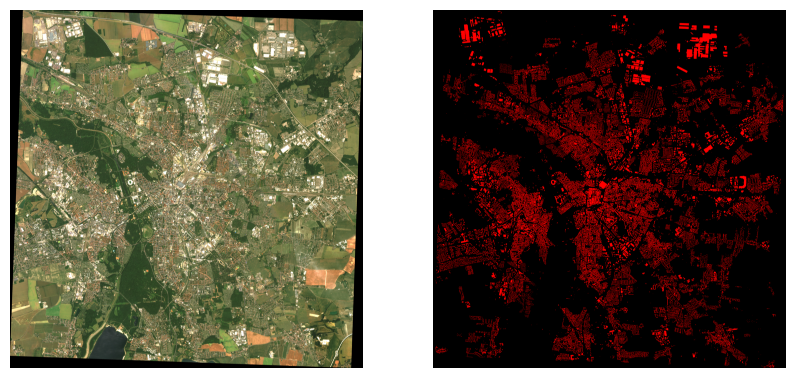

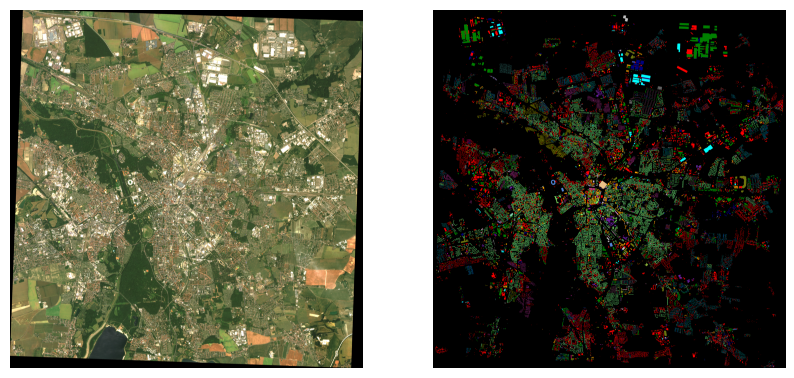

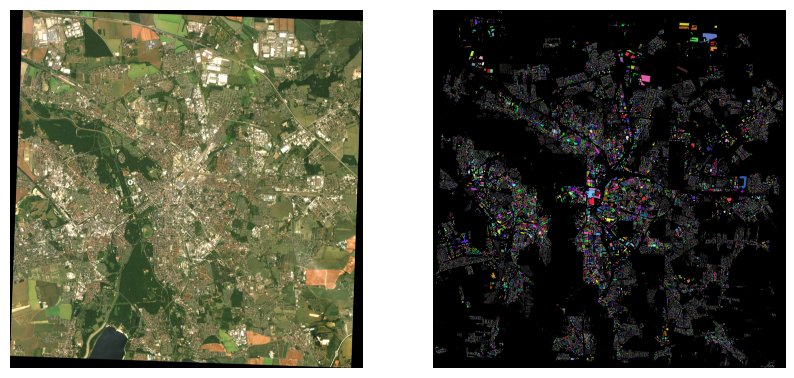

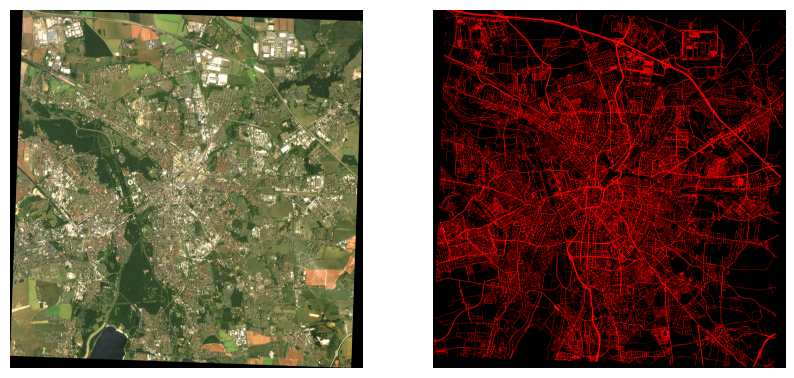

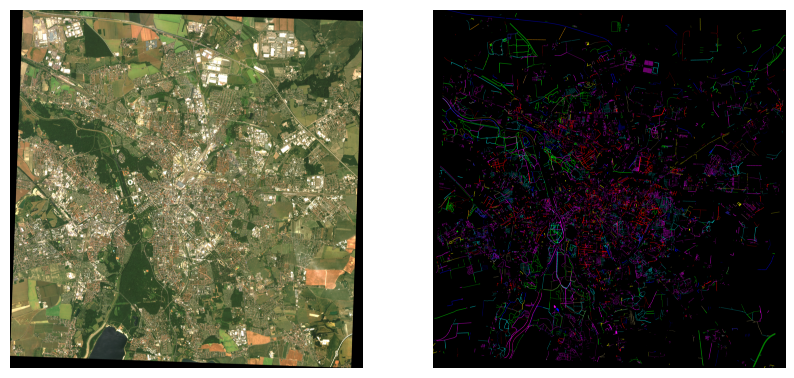

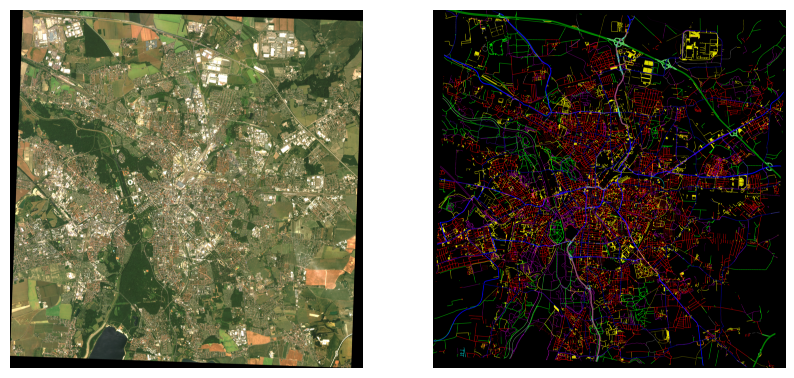

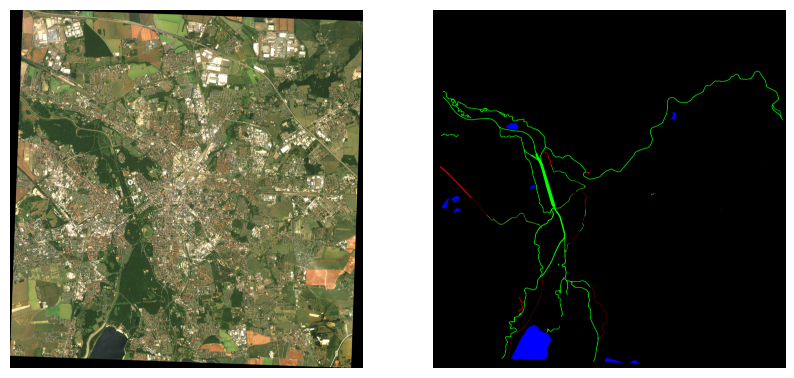

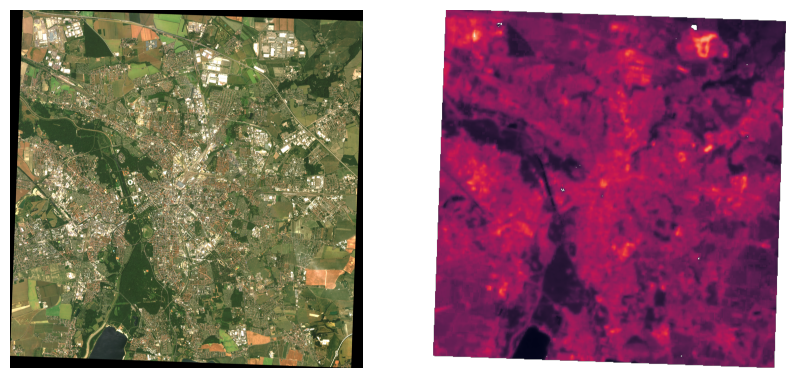

In [12]:
def plot_side_by_side(images, cmap_secondary=None):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for i, img in enumerate(images):
        if cmap_secondary is not None and i == 1:
            axes[i].imshow(img, cmap=cmap_secondary)
        else:
            axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

plot_side_by_side([rgb_image, ndvi_mask], cmap_secondary='RdYlGn')
plot_side_by_side([rgb_image, landuse_mask_rgb])
plot_side_by_side([rgb_image, buildings_mask_rgb])
plot_side_by_side([rgb_image, buildings_services_mask_rgb])
plot_side_by_side([rgb_image, buildings_height_mask_rgb])
plot_side_by_side([rgb_image, streets_mask_rgb])
plot_side_by_side([rgb_image, streets_surface_mask_rgb])
plot_side_by_side([rgb_image, streets_service_mask_rgb])
plot_side_by_side([rgb_image, water_mask_rgb])
plot_side_by_side([rgb_image, lst_mask], cmap_secondary='rocket')